In [1]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import plotly.express as px

import collections
from plotly import graph_objects as go
import emoji

import sys
sys.path.append("..")

flatten = lambda t: [item for sublist in t for item in sublist]
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [2]:
comment_df = pd.read_excel(r"..\data\psaw_comments_from_sept1_pol.xlsx")
comment_df["lens"] = comment_df.text.str.split().map(lambda x: len(x))
comment_df.head()

,Unnamed: 0,comment_id,text,author,upvotes,timestamp,post_id,lens
0,0,hfu3t3z,Minden oké otthon?,drakvuf,15,1633686153,q3uef4,3
1,1,hfu3wlv,"Ez azért elég izzadtságszagú azt tekintve, hog...",Debre1024,6,1633686239,q3uef4,15
2,2,hfu491h,téged ki bántott :(,Endymion2748,6,1633686552,q3uef4,4
3,3,hfu407d,Még nincs szombat...,LazyTomTom,3,1633686328,q3uef4,3
4,4,hfu4nyg,"Ezazz! Te is szereted ha megbasznak szárazon, ...",DrTorrente,3,1633686923,q3uef4,21


In [3]:
comment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12950 entries, 0 to 12949
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12950 non-null  int64 
 1   comment_id  12950 non-null  object
 2   text        12950 non-null  object
 3   author      12950 non-null  object
 4   upvotes     12950 non-null  int64 
 5   timestamp   12950 non-null  int64 
 6   post_id     12950 non-null  object
 7   lens        12950 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 809.5+ KB


# Cleaning

## Remove
-  web links
-  user mentions
-  emojis
- punctuation
- numbers
- newline characters
- tabs
<br>

- make lowercase


In [4]:
#Remove web links
print("Before:\n",comment_df["text"].iloc[25])
print("Num of http:", comment_df["text"].map(lambda x: "http" in x).sum())


comment_df["text"] = comment_df["text"].map( lambda x: re.sub(r'http\S+', '', x) )
print("\nAfter:\n",comment_df["text"].iloc[25])
print("Num of http:",comment_df.text.map(lambda x: "http" in x).sum())
print("Num of https:",comment_df.text.map(lambda x: "https" in x).sum())



Before:
 [u/shiffer_andras](https://youtu.be/dQw4w9WgXcQ) vélemény?
Num of http: 589

After:
 [u/shiffer_andras]( vélemény?
Num of http: 0
Num of https: 0


In [5]:
#remove user mentions, u/shiffer_andras vélemény?

print("Before:\n",comment_df["text"].iloc[25])
print("Num of user mentions:", comment_df["text"].map(lambda x: "u/" in x).sum())

comment_df["text"] = comment_df["text"].map( lambda x: re.sub(r"u/\S+", "", x))

print("\nAfter:\n",comment_df["text"].iloc[25])
print("Num of user mentions:",comment_df.text.map(lambda x: "u/" in x).sum())
print("Num of user mentions:",comment_df.text.map(lambda x: "u/" in x).sum())

Before:
 [u/shiffer_andras]( vélemény?
Num of user mentions: 47

After:
 [ vélemény?
Num of user mentions: 0
Num of user mentions: 0


In [6]:
#remove emojis, lmao, fosik a malac
print("Before:",comment_df.text[15]) 
comment_df["text"] = comment_df["text"].map( lambda text: emoji.get_emoji_regexp().sub(u'', text) )
print("After:",comment_df.text[15])

Before: Lmao, fosik a malac 🥴
After: Lmao, fosik a malac 


In [7]:
from string import punctuation, digits

#Remove numbers
for d in digits:
    comment_df["text"] = comment_df["text"].str.replace(d, "")

#Remove punctuations
for s in punctuation:
    comment_df["text"] = comment_df["text"].str.replace(s, "")

#Make lowercase
comment_df["text"] = comment_df["text"].str.lower()

#remove newline 
comment_df["text"] = comment_df["text"].str.replace("\n", " ")

#remove newline 
comment_df["text"] = comment_df["text"].str.replace("\t", " ")

In [8]:
# split every comment on whitespace
comment_df.text = comment_df.text.str.split(" ")

#remove empty string ''
notEmpty = lambda word: word != ""
comment_df.text = comment_df.text.map(lambda line: list(filter(notEmpty, line)))

In [9]:
comment_df.drop(index =[ 1209, 1220, 4802, 10207], inplace = True)

In [10]:
comment_df.text

0                                    [minden, oké, otthon]
1        [ez, azért, elég, izzadtságszagú, azt, tekintv...
2                                     [téged, ki, bántott]
3                                    [még, nincs, szombat]
4        [ezazz, te, is, szereted, ha, megbasznak, szár...
                               ...                        
12945    [protip, for, life, a, bírósági, ítéleteket, m...
12946    [végül, a, hangfelvételen, a, dulakodás, is, c...
12947    [schiffer, és, srb, urak, kavarják, a, szart, ...
12948    [milyen, érdekes, hogy, ez, a, per, is, pont, ...
12949                                 [de, schiffer, fasz]
Name: text, Length: 12946, dtype: object

# Removing stopwords and stemming

In [11]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
hu_stop = stopwords.words("hungarian")
print(hu_stop)

['a', 'ahogy', 'ahol', 'aki', 'akik', 'akkor', 'alatt', 'által', 'általában', 'amely', 'amelyek', 'amelyekben', 'amelyeket', 'amelyet', 'amelynek', 'ami', 'amit', 'amolyan', 'amíg', 'amikor', 'át', 'abban', 'ahhoz', 'annak', 'arra', 'arról', 'az', 'azok', 'azon', 'azt', 'azzal', 'azért', 'aztán', 'azután', 'azonban', 'bár', 'be', 'belül', 'benne', 'cikk', 'cikkek', 'cikkeket', 'csak', 'de', 'e', 'eddig', 'egész', 'egy', 'egyes', 'egyetlen', 'egyéb', 'egyik', 'egyre', 'ekkor', 'el', 'elég', 'ellen', 'elõ', 'elõször', 'elõtt', 'elsõ', 'én', 'éppen', 'ebben', 'ehhez', 'emilyen', 'ennek', 'erre', 'ez', 'ezt', 'ezek', 'ezen', 'ezzel', 'ezért', 'és', 'fel', 'felé', 'hanem', 'hiszen', 'hogy', 'hogyan', 'igen', 'így', 'illetve', 'ill.', 'ill', 'ilyen', 'ilyenkor', 'ison', 'ismét', 'itt', 'jó', 'jól', 'jobban', 'kell', 'kellett', 'keresztül', 'keressünk', 'ki', 'kívül', 'között', 'közül', 'legalább', 'lehet', 'lehetett', 'legyen', 'lenne', 'lenni', 'lesz', 'lett', 'maga', 'magát', 'majd', 'majd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#Loading additional stopwords from github

with open(r"..\data\misc\hu_stopwords.txt", "r",  encoding='utf-8') as f:
    additional_stopwords = f.readlines()

additional_stopwords = [ word.replace("\n","") for word in additional_stopwords ]
hu_stop += additional_stopwords
hu_stop += ["kb", "es", "", "  "]
hu_stop = list(set(hu_stop))

In [13]:
#filtering stopwords
def filterStopword(word):
    if word in hu_stop:
        return False
    else:
        return True

#filtered_text = list(filter(filterStopword, comment_words))
comment_df.text = comment_df.text.map(lambda line: list(filter(filterStopword, line)))

In [14]:
cntr = collections.Counter( flatten(comment_df.text) )
ws, cnt = zip( *cntr.most_common() )

fig = go.Figure([go.Bar(x=ws[:25], y=cnt[:25], marker_color = 'rgb(17,165,121)')])
fig.update_yaxes(type="log")

fig.update_traces(marker_line_color='rgb(17,165,121)',
                  marker_line_width=0.5, opacity=0.6)

fig.update_layout(title="Barchart of the most frequent words",
                  yaxis_title="word frequency",)

fig.show()

In [15]:
"""comment_df["text"] = comment_df.text.map( lambda word: " ".join(list(filter(filterStopword, word.split(" ")))))
comment_df.text.head()"""

'comment_df["text"] = comment_df.text.map( lambda word: " ".join(list(filter(filterStopword, word.split(" ")))))\ncomment_df.text.head()'

In [16]:
from nltk.stem import SnowballStemmer

#Stemming tweets
snow = SnowballStemmer('hungarian',ignore_stopwords=True)

comment_df.text = comment_df.text.map(lambda line: " ".join([snow.stem(word) for word in line]))

comment_df = comment_df[comment_df.text.map(lambda line: len(line.split(" "))) > 6]
comment_df = comment_df[comment_df.text.map(lambda line: len(line.split(" "))) < 100]
comment_df = comment_df.reset_index().drop(columns = ["index"])
#comment_df.to_excel("..\data\cleaned_swed_stemmed.xlsx")

In [17]:
comment_df.shape

(6727, 8)

# TF-IDF

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer()

In [20]:
c.fit_transform(comment_df.text).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

(1.0, 60.0)

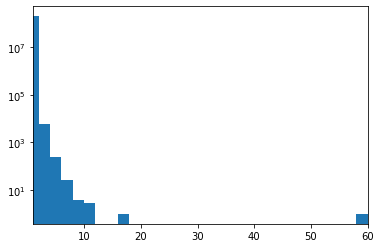

In [21]:
plt.hist(c.fit_transform(comment_df.text).toarray().flatten(), bins = 30)
plt.yscale("log")
plt.xlim(1,60)

In [22]:
term_doc = pd.DataFrame(c.fit_transform(comment_df.text.astype('U')).toarray())
#term_doc = pd.get_dummies(comment_df.text)

term_frequency = term_doc.divide( term_doc.sum(axis="columns"), axis="rows")
term_frequency.sum(axis="columns")

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6722    1.0
6723    1.0
6724    1.0
6725    1.0
6726    1.0
Length: 6727, dtype: float64

In [23]:
#(term_doc.sum(axis="columns") < 1).sum()
term_doc.columns = c.get_feature_names()
#c.get_feature_names(term_doc)
term_doc

C:\Users\balin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aaaaa,aaaaaa,aaaaaaaaaa,aacgtatgggcctatatttgcccgacatagggcggcctaattgattgacatagcgtatgggcctatgacataggcatagggcttatgaccaaggttaag,aacgtatgggcctatatttgcccgacataggggggcctaattgattgacatagcgtatgggcctatgacataggcatagggcttatgaccaaggttaag,abbahagyta,abbol,abdlocker,abl,abnormális,...,őszint,őszinte,őszinteség,őszintébb,őszintétlen,ősztől,őszöd,őzbak,őélkasdjfasj,űz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6723,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#check which elements are none
comment_df.reset_index().drop(columns = ["index"])[term_frequency.isna().T.any()]

,Unnamed: 0,comment_id,text,author,upvotes,timestamp,post_id,lens


In [29]:
term_doc.iloc[:,3]

0       0
1       0
2       0
3       0
4       0
       ..
6722    0
6723    0
6724    0
6725    0
6726    0
Name: aacgtatgggcctatatttgcccgacatagggcggcctaattgattgacatagcgtatgggcctatgacataggcatagggcttatgaccaaggttaag, Length: 6727, dtype: int64

In [30]:
# idf number of documents / number of documents containing the word
temp = np.zeros(len(term_doc.columns))

for i in range(len(temp)):
    temp[i] = sum(term_doc.iloc[:,i].map(lambda x: 1 if x > 0 else 0))
    
idf = np.log(len(term_doc) / temp)

In [31]:
pd.DataFrame(c.fit_transform(comment_df.text).toarray()).shape

(6727, 29520)

For some very odd reason using count vectorizer produced some (4) NaN values, which wallopped the SVD calculation

In [32]:
(term_doc.sum(axis="columns")<1).sum()
#c.get_feature_names_out(2)
import sklearn
sklearn.__version__

'1.0'

In [ ]:
term_doc.shape, len(idf)

((6731, 6671), 6671)

(array([6.0000e+00, 3.0000e+00, 1.1000e+01, 2.0000e+01, 3.3000e+01,
        4.1000e+01, 7.0000e+01, 1.2800e+02, 1.5700e+02, 2.2500e+02,
        2.9400e+02, 4.1200e+02, 5.0700e+02, 6.7300e+02, 8.4400e+02,
        1.6430e+03, 1.7240e+03, 3.8180e+03, 0.0000e+00, 1.8911e+04]),
 array([2.11438422, 2.44935923, 2.78433425, 3.11930927, 3.45428429,
        3.7892593 , 4.12423432, 4.45920934, 4.79418435, 5.12915937,
        5.46413439, 5.7991094 , 6.13408442, 6.46905944, 6.80403446,
        7.13900947, 7.47398449, 7.80895951, 8.14393452, 8.47890954,
        8.81388456]),
 <BarContainer object of 20 artists>)

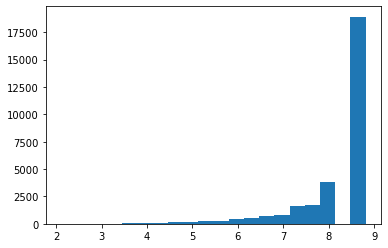

In [33]:
plt.hist(idf, bins = 20)

In [34]:
term_frequency = term_doc.divide( term_doc.sum(axis="columns"), axis="rows")
term_frequency.sum(axis="columns")

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6722    1.0
6723    1.0
6724    1.0
6725    1.0
6726    1.0
Length: 6727, dtype: float64

In [35]:
tf_idf = term_frequency * idf


In [41]:
#LSA method: making SVD with the tf_idf, then taking the first n most significant vectors to score the documents

from sklearn.decomposition import TruncatedSVD
n_comp = 7
svd = TruncatedSVD(n_components = n_comp)
lsa = svd.fit_transform(tf_idf)

In [42]:
topic_encoded_df = pd.DataFrame(lsa, index = comment_df.index,
                                columns = [f"topic{i}" for i in range(n_comp)])
topic_encoded_df["text"] = comment_df.text

In [43]:
encoding_matrix = pd.DataFrame(svd.components_, 
                               index = [f"topic{i}" for i in range(n_comp)], 
                               columns = c.get_feature_names())

C:\Users\balin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [44]:
top_by_topic = pd.DataFrame()
for col in encoding_matrix.index:
    topic_temp_df = pd.DataFrame(encoding_matrix.T.sort_values(col, axis = "rows", ascending = False, 
                                                               key = np.abs)[col][:15]).reset_index()
    topic_temp_df.columns = [col, col+"_value"]
    top_by_topic = pd.concat([top_by_topic, topic_temp_df], axis = 1)

In [48]:
top_by_topic.to_excel(r"..\data\top_by_topic_LSI.xlsx")
top_by_topic


,topic0,topic0_value,topic1,topic1_value,topic2,topic2_value,topic3,topic3_value,topic4,topic4_value,topic5,topic5_value,topic6,topic6_value
0,dobrev,0.275129,poll,0.698320,dobrev,-0.295531,karácsony,0.334473,stop,0.631816,tóth,0.611525,the,0.298485
1,mzp,0.229880,peter,0.598082,nap,0.270916,dobrev,0.312081,gyurcsány,0.416867,csa,0.578525,onlin,0.259320
2,karácsony,0.221081,tegyel,0.137998,próbál,0.248543,mzp,0.246360,dobrev,-0.319287,hadházy,0.191263,dobrev,-0.257683
3,fidesz,0.196126,reportol,0.126285,karácsony,-0.243735,végrehajtv,0.194559,soros,0.175365,kihátrál,0.130459,mzp,0.253210
4,fog,0.191463,tam,0.122562,végrehajtv,0.241405,átlépt,0.192273,karácsony,0.143315,fidesz,-0.121641,fidesz,-0.235593
5,szavazn,0.152273,ci,0.116681,átlépt,0.238809,korlát,0.187435,szavaz,-0.142244,zugló,0.118876,perc,0.180663
6,gyurcsány,0.137208,uj,0.110229,posz,0.237780,posz,0.180900,aláírás,0.093600,fog,0.111660,bizonyite,0.143985
7,ellenze,0.135590,vegzetes,0.076240,poszt,0.236134,poszt,0.179463,szavazn,-0.091675,karácsony,0.094834,szavazás,0.134188
8,ember,0.132539,figyelmes,0.074699,korlát,0.234496,stop,0.174868,fog,-0.090188,ákos,0.083024,fog,0.132937
9,szavaz,0.130417,lecsap,0.074699,automatikus,0.211905,próbál,0.171217,forduló,-0.084362,mzp,-0.081490,to,0.132515
